# CatBoost - Categorical Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import (cross_val_score,
                                     cross_val_predict,
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split)
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             auc,
                             roc_auc_score,
                             precision_recall_curve,
                             f1_score)

In [96]:
##########################- Accuracy -###########################################
def accuracy(model, x_val, y_val):
    pred = model.predict(x_val)
    return accuracy_score(y_val, pred)
##########################- Precision -##########################################
def precision(model, x_val, y_val):
    pred = model.predict(x_val)
    return precision_score(y_val, pred)
##########################- Recall -#############################################
def recall(model, x_val, y_val):
    pred = model.predict(x_val)
    return recall_score(y_val, pred)
##########################- Classification Repor -###############################
def class_report(model, x_val, y_val):
    pred = model.predict(x_val)
    return classification_report(y_val, pred)
##########################- ROC -################################################
def roc(model, X_test, y_test):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot

In [2]:
base_credit = pd.read_csv('credit_risk_dataset.csv')

In [3]:
base_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
base_credit

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [5]:
base_credit.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
base_credit["person_emp_length"].fillna(base_credit["person_emp_length"].median(), inplace=True)

In [7]:
base_credit["loan_int_rate"].fillna(base_credit["loan_int_rate"].median(), inplace=True)

In [8]:
base_credit.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [9]:
base_credit.duplicated().sum()

165

In [10]:
base_credit.drop_duplicates(inplace=True)

In [21]:
X_credit = base_credit[['person_age', 'person_income', 'person_home_ownership',
                        'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
                        'loan_int_rate', 'loan_percent_income',
                        'cb_person_default_on_file', 'cb_person_cred_hist_length']]
y_credit = base_credit['loan_status']

In [22]:
X_credit = pd.get_dummies(X_credit)

In [23]:
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit,y_credit, test_size = 0.3, random_state=84)

In [17]:
from xgboost import XGBClassifier

In [25]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic',eval_metric='logloss' ,use_label_encoder=False, random_state=2)

In [26]:
# Obtain scores of cross-validation
scores = cross_val_score(model, X_credit, y_credit, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.91 0.9  0.92 0.92 0.93]
Accuracy mean: 0.92


In [29]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [39]:
def xgboost_hyperarameter_search( X, y, params, random=False):

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic' ,eval_metric='logloss' ,use_label_encoder=False, random_state=2)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)

    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)

    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [40]:
xgboost_hyperarameter_search(X_credit_train,y_credit_train,params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                                                   'min_child_weight':[1, 2, 3, 4, 5],
                                                                   'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
                                                                   'max_depth':[1, 2, 3, 4, 5, None],
                                                                   'n_estimators':[2, 25, 50, 75, 100]},
                                                                   random=True)

Best params: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': None, 'learning_rate': 0.3}
Best score: 0.93218


In [43]:
optimized_xgboost = XGBClassifier(booster='gbtree',
                                  objective='binary:logistic',
                                  eval_metric='logloss',
                                  subsample=0.6,
                                  min_child_weight= 3,
                                  learning_rate=0.3,
                                  max_depth= None,
                                  n_estimators=100,
                                  use_label_encoder=False,
                                  random_state=2)
optimized_xgboost.fit(X_credit_train,y_credit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=2, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Text(0, 0.5, 'True positive rate (TPR)')

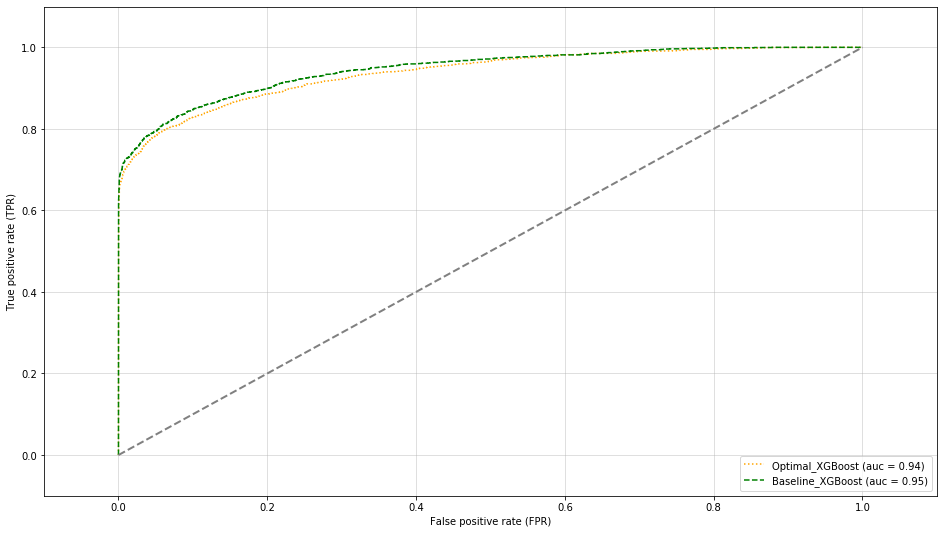

In [48]:
colors = ['orange', 'green']
linestyles = [':', '--']
all_clf = [optimized_xgboost, model]
clf_labels = ['Optimal_XGBoost','Baseline_XGBoost']
plt.figure(figsize=(16,9))
for clf, label, clr, ls  in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_credit_pred = clf.fit(X_credit_train,
                     y_credit_train).predict_proba(X_credit_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_credit_test,
                                     y_score=y_credit_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)

Optimal_XGBoost (F1-Score = 0.81)
Baseline_XGBoost (F1-Score = 0.82)


Text(0, 0.5, 'Precision')

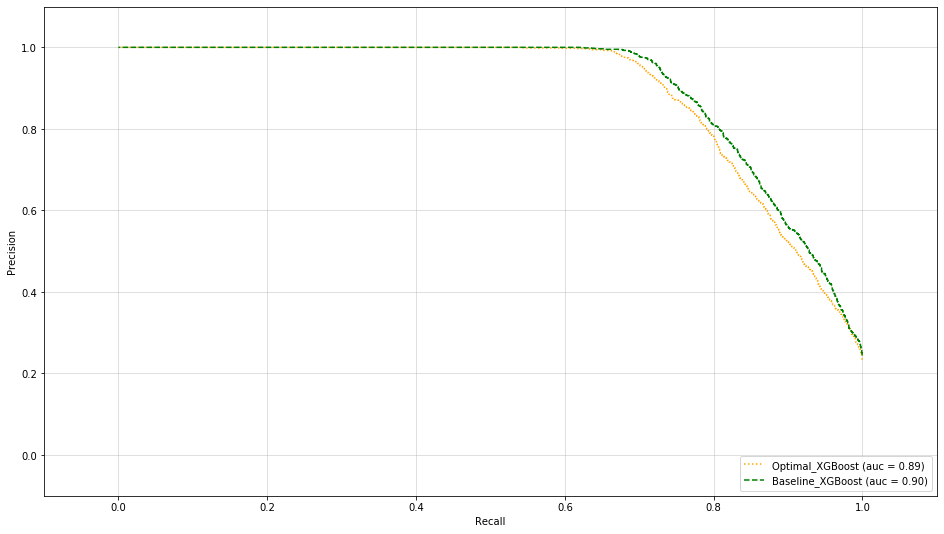

In [53]:
colors = ['orange', 'green']
linestyles = [':', '--']
all_clf = [optimized_xgboost, model]
clf_labels = ['Optimal_XGBoost','Baseline_XGBoost']
plt.figure(figsize=(16,9))
for clf, label, clr, ls  in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_credit_pred = clf.fit(X_credit_train,
                            y_credit_train).predict_proba(X_credit_test)[:, 1]
    yhat = clf.predict(X_credit_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_credit_test, y_credit_pred)
    lr_f1, lr_auc = f1_score(y_credit_test, yhat), auc(lr_recall, lr_precision)
    plt.plot(lr_recall, lr_precision,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, lr_auc))
    print('%s (F1-Score = %0.2f)' % (label,lr_f1))
plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [58]:
# Predict labels of test set, y_pred
y_pred = model.predict(X_credit_test)


print(confusion_matrix(y_credit_test, y_pred))

print(classification_report(y_credit_test, y_pred))

[[7484   77]
 [ 595 1569]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7561
           1       0.95      0.73      0.82      2164

    accuracy                           0.93      9725
   macro avg       0.94      0.86      0.89      9725
weighted avg       0.93      0.93      0.93      9725



In [59]:
# Predict labels of test set, y_pred
y_optimized_pred = optimized_xgboost.predict(X_credit_test)


print(confusion_matrix(y_credit_test, y_optimized_pred))

print(classification_report(y_credit_test, y_optimized_pred))

[[7438  123]
 [ 609 1555]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7561
           1       0.93      0.72      0.81      2164

    accuracy                           0.92      9725
   macro avg       0.93      0.85      0.88      9725
weighted avg       0.92      0.92      0.92      9725



In [3]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [8]:
catboost_model = CatBoostClassifier(
                                      #custom_loss=[metrics.Accuracy()],
                                      random_seed=42,
                                      #logging_level='Silent'
                                    )

In [63]:
catboost_model.fit( X_credit_train, y_credit_train,
                    #cat_features=categorical_features_indices,
                    #eval_set=(X_credit_test, y_credit_test),
                    #     logging_level='Verbose',  # you can uncomment this for text output
                    #plot=True
                    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
# Obtain scores of cross-validation
catboost_scores = cross_val_score(catboost_model, X_credit_train, y_credit_train, cv=5)

# Display accuracy
print('Accuracy:', np.round(catboost_scores, 2))

# Display mean accuracy

Learning rate set to 0.035522
0:	learn: 0.6556683	total: 38.9ms	remaining: 38.9s
1:	learn: 0.6253857	total: 44.6ms	remaining: 22.3s
2:	learn: 0.5975147	total: 50ms	remaining: 16.6s
3:	learn: 0.5714721	total: 55.3ms	remaining: 13.8s
4:	learn: 0.5446398	total: 60.6ms	remaining: 12.1s
5:	learn: 0.5238807	total: 65.8ms	remaining: 10.9s
6:	learn: 0.5024892	total: 71.1ms	remaining: 10.1s
7:	learn: 0.4830704	total: 77.2ms	remaining: 9.57s
8:	learn: 0.4654583	total: 82.7ms	remaining: 9.1s
9:	learn: 0.4489191	total: 87.9ms	remaining: 8.71s
10:	learn: 0.4349280	total: 93.3ms	remaining: 8.38s
11:	learn: 0.4209302	total: 98.7ms	remaining: 8.13s
12:	learn: 0.4086895	total: 104ms	remaining: 7.92s
13:	learn: 0.3968797	total: 112ms	remaining: 7.85s
14:	learn: 0.3870410	total: 117ms	remaining: 7.69s
15:	learn: 0.3787388	total: 123ms	remaining: 7.54s
16:	learn: 0.3701657	total: 128ms	remaining: 7.41s
17:	learn: 0.3611904	total: 133ms	remaining: 7.28s
18:	learn: 0.3540045	total: 139ms	remaining: 7.19s
19

In [69]:
# Display accuracy
print('Accuracy:', np.round(catboost_scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (catboost_scores.mean()))

Accuracy: [0.94 0.93 0.94 0.94 0.94]
Accuracy mean: 0.94


In [70]:
base_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           32416 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               32416 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [71]:
base_credit

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [4]:
X_credit_cat = base_credit[['person_age', 'person_income', 'person_home_ownership',
                        'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
                        'loan_int_rate', 'loan_percent_income',
                        'cb_person_default_on_file', 'cb_person_cred_hist_length']]
y_credit_cat = base_credit['loan_status']

In [5]:
X_credit_cat_train, X_credit_cat_test, y_credit_cat_train, y_credit_cat_test = train_test_split(X_credit_cat,y_credit_cat, test_size = 0.3, random_state=84)

In [6]:
categorical_features_indices = ['person_home_ownership',
                                'loan_intent',
                                'loan_grade',
                                'cb_person_default_on_file'
                                ]

In [9]:
catboost_model.fit( X_credit_cat_train, y_credit_cat_train,
                    cat_features=categorical_features_indices,
                    #eval_set=(X_credit_test, y_credit_test),
                    #     logging_level='Verbose',  # you can uncomment this for text output
                    plot=True
                    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.039158
0:	learn: 0.6527763	total: 229ms	remaining: 3m 48s
1:	learn: 0.6185258	total: 261ms	remaining: 2m 10s
2:	learn: 0.5870744	total: 326ms	remaining: 1m 48s
3:	learn: 0.5590413	total: 361ms	remaining: 1m 29s
4:	learn: 0.5364558	total: 397ms	remaining: 1m 19s
5:	learn: 0.5163915	total: 430ms	remaining: 1m 11s
6:	learn: 0.4944829	total: 477ms	remaining: 1m 7s
7:	learn: 0.4787469	total: 554ms	remaining: 1m 8s
8:	learn: 0.4604951	total: 583ms	remaining: 1m 4s
9:	learn: 0.4432680	total: 620ms	remaining: 1m 1s
10:	learn: 0.4271795	total: 661ms	remaining: 59.4s
11:	learn: 0.4134774	total: 696ms	remaining: 57.3s
12:	learn: 0.3997479	total: 732ms	remaining: 55.6s
13:	learn: 0.3877933	total: 825ms	remaining: 58.1s
14:	learn: 0.3773140	total: 853ms	remaining: 56s
15:	learn: 0.3662766	total: 887ms	remaining: 54.5s
16:	learn: 0.3570353	total: 923ms	remaining: 53.4s
17:	learn: 0.3495050	total: 961ms	remaining: 52.4s
18:	learn: 0.3418593	total: 997ms	remaining: 51.5s
19:	lea

161:	learn: 0.2070335	total: 6.92s	remaining: 35.8s
162:	learn: 0.2069294	total: 6.95s	remaining: 35.7s
163:	learn: 0.2066611	total: 6.98s	remaining: 35.6s
164:	learn: 0.2065763	total: 7.02s	remaining: 35.5s
165:	learn: 0.2065126	total: 7.07s	remaining: 35.5s
166:	learn: 0.2064614	total: 7.13s	remaining: 35.6s
167:	learn: 0.2063879	total: 7.17s	remaining: 35.5s
168:	learn: 0.2062816	total: 7.22s	remaining: 35.5s
169:	learn: 0.2061062	total: 7.26s	remaining: 35.5s
170:	learn: 0.2057544	total: 7.3s	remaining: 35.4s
171:	learn: 0.2056840	total: 7.34s	remaining: 35.3s
172:	learn: 0.2056461	total: 7.38s	remaining: 35.3s
173:	learn: 0.2055500	total: 7.42s	remaining: 35.2s
174:	learn: 0.2051800	total: 7.47s	remaining: 35.2s
175:	learn: 0.2049610	total: 7.51s	remaining: 35.2s
176:	learn: 0.2048670	total: 7.54s	remaining: 35.1s
177:	learn: 0.2048165	total: 7.57s	remaining: 35s
178:	learn: 0.2047886	total: 7.6s	remaining: 34.9s
179:	learn: 0.2046868	total: 7.63s	remaining: 34.8s
180:	learn: 0.20

321:	learn: 0.1898779	total: 14.4s	remaining: 30.4s
322:	learn: 0.1897254	total: 14.5s	remaining: 30.3s
323:	learn: 0.1896015	total: 14.5s	remaining: 30.3s
324:	learn: 0.1895068	total: 14.5s	remaining: 30.2s
325:	learn: 0.1893540	total: 14.6s	remaining: 30.2s
326:	learn: 0.1892044	total: 14.6s	remaining: 30.1s
327:	learn: 0.1891422	total: 14.7s	remaining: 30s
328:	learn: 0.1890751	total: 14.7s	remaining: 30.1s
329:	learn: 0.1889572	total: 14.8s	remaining: 30s
330:	learn: 0.1888763	total: 14.8s	remaining: 30s
331:	learn: 0.1887752	total: 14.9s	remaining: 29.9s
332:	learn: 0.1887437	total: 14.9s	remaining: 29.9s
333:	learn: 0.1886719	total: 14.9s	remaining: 29.8s
334:	learn: 0.1886079	total: 15s	remaining: 29.8s
335:	learn: 0.1885085	total: 15s	remaining: 29.7s
336:	learn: 0.1883466	total: 15.1s	remaining: 29.8s
337:	learn: 0.1882389	total: 15.2s	remaining: 29.7s
338:	learn: 0.1881509	total: 15.2s	remaining: 29.7s
339:	learn: 0.1881129	total: 15.3s	remaining: 29.7s
340:	learn: 0.1880530	

481:	learn: 0.1773095	total: 22s	remaining: 23.6s
482:	learn: 0.1772262	total: 22s	remaining: 23.6s
483:	learn: 0.1772259	total: 22.1s	remaining: 23.5s
484:	learn: 0.1771646	total: 22.1s	remaining: 23.5s
485:	learn: 0.1771145	total: 22.1s	remaining: 23.4s
486:	learn: 0.1770724	total: 22.2s	remaining: 23.4s
487:	learn: 0.1768888	total: 22.3s	remaining: 23.4s
488:	learn: 0.1768381	total: 22.3s	remaining: 23.4s
489:	learn: 0.1767442	total: 22.4s	remaining: 23.4s
490:	learn: 0.1766102	total: 22.5s	remaining: 23.3s
491:	learn: 0.1766014	total: 22.5s	remaining: 23.3s
492:	learn: 0.1765393	total: 22.6s	remaining: 23.2s
493:	learn: 0.1764439	total: 22.6s	remaining: 23.2s
494:	learn: 0.1764226	total: 22.7s	remaining: 23.1s
495:	learn: 0.1763631	total: 22.7s	remaining: 23.1s
496:	learn: 0.1763546	total: 22.7s	remaining: 23s
497:	learn: 0.1763021	total: 22.8s	remaining: 23s
498:	learn: 0.1762144	total: 22.9s	remaining: 23s
499:	learn: 0.1761554	total: 22.9s	remaining: 22.9s
500:	learn: 0.1760684	

641:	learn: 0.1669585	total: 29.8s	remaining: 16.6s
642:	learn: 0.1668933	total: 29.8s	remaining: 16.6s
643:	learn: 0.1668562	total: 29.9s	remaining: 16.5s
644:	learn: 0.1667800	total: 30s	remaining: 16.5s
645:	learn: 0.1667421	total: 30s	remaining: 16.4s
646:	learn: 0.1667201	total: 30.1s	remaining: 16.4s
647:	learn: 0.1666639	total: 30.1s	remaining: 16.3s
648:	learn: 0.1666623	total: 30.1s	remaining: 16.3s
649:	learn: 0.1666178	total: 30.2s	remaining: 16.2s
650:	learn: 0.1665674	total: 30.2s	remaining: 16.2s
651:	learn: 0.1665241	total: 30.3s	remaining: 16.2s
652:	learn: 0.1664965	total: 30.4s	remaining: 16.1s
653:	learn: 0.1664280	total: 30.4s	remaining: 16.1s
654:	learn: 0.1663508	total: 30.5s	remaining: 16.1s
655:	learn: 0.1662784	total: 30.5s	remaining: 16s
656:	learn: 0.1662141	total: 30.5s	remaining: 15.9s
657:	learn: 0.1661294	total: 30.6s	remaining: 15.9s
658:	learn: 0.1660771	total: 30.7s	remaining: 15.9s
659:	learn: 0.1660499	total: 30.8s	remaining: 15.9s
660:	learn: 0.1659

803:	learn: 0.1585752	total: 37.6s	remaining: 9.17s
804:	learn: 0.1585306	total: 37.7s	remaining: 9.13s
805:	learn: 0.1585202	total: 37.7s	remaining: 9.07s
806:	learn: 0.1585121	total: 37.7s	remaining: 9.03s
807:	learn: 0.1584712	total: 37.8s	remaining: 8.98s
808:	learn: 0.1584633	total: 37.8s	remaining: 8.93s
809:	learn: 0.1584262	total: 37.9s	remaining: 8.89s
810:	learn: 0.1583731	total: 37.9s	remaining: 8.84s
811:	learn: 0.1583099	total: 38s	remaining: 8.79s
812:	learn: 0.1582451	total: 38s	remaining: 8.74s
813:	learn: 0.1581080	total: 38.1s	remaining: 8.7s
814:	learn: 0.1580726	total: 38.1s	remaining: 8.66s
815:	learn: 0.1580229	total: 38.2s	remaining: 8.61s
816:	learn: 0.1579459	total: 38.2s	remaining: 8.56s
817:	learn: 0.1578106	total: 38.3s	remaining: 8.51s
818:	learn: 0.1577524	total: 38.3s	remaining: 8.46s
819:	learn: 0.1577138	total: 38.3s	remaining: 8.41s
820:	learn: 0.1576843	total: 38.4s	remaining: 8.37s
821:	learn: 0.1576484	total: 38.4s	remaining: 8.32s
822:	learn: 0.157

962:	learn: 0.1508313	total: 45s	remaining: 1.73s
963:	learn: 0.1507824	total: 45.1s	remaining: 1.68s
964:	learn: 0.1507115	total: 45.1s	remaining: 1.64s
965:	learn: 0.1506678	total: 45.2s	remaining: 1.59s
966:	learn: 0.1506162	total: 45.2s	remaining: 1.54s
967:	learn: 0.1505931	total: 45.2s	remaining: 1.5s
968:	learn: 0.1505539	total: 45.3s	remaining: 1.45s
969:	learn: 0.1505435	total: 45.3s	remaining: 1.4s
970:	learn: 0.1505293	total: 45.4s	remaining: 1.35s
971:	learn: 0.1504735	total: 45.5s	remaining: 1.31s
972:	learn: 0.1503953	total: 45.5s	remaining: 1.26s
973:	learn: 0.1503465	total: 45.6s	remaining: 1.22s
974:	learn: 0.1502692	total: 45.6s	remaining: 1.17s
975:	learn: 0.1502251	total: 45.6s	remaining: 1.12s
976:	learn: 0.1501977	total: 45.7s	remaining: 1.07s
977:	learn: 0.1501615	total: 45.7s	remaining: 1.03s
978:	learn: 0.1500955	total: 45.7s	remaining: 981ms
979:	learn: 0.1500656	total: 45.8s	remaining: 934ms
980:	learn: 0.1500102	total: 45.8s	remaining: 888ms
981:	learn: 0.14

In [81]:
# Predict labels of test set, y_pred
y_optimized_pred = catboost_model.predict(X_credit_cat_test)


print(confusion_matrix(y_credit_cat_test, y_optimized_pred))

print(classification_report(y_credit_cat_test, y_optimized_pred))

[[7530   31]
 [ 612 1552]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7561
           1       0.98      0.72      0.83      2164

    accuracy                           0.93      9725
   macro avg       0.95      0.86      0.89      9725
weighted avg       0.94      0.93      0.93      9725



In [83]:
import catboost

In [84]:
train_pool = catboost.Pool(X_credit_cat_train, y_credit_cat_train, cat_features=categorical_features_indices)
test_pool = catboost.Pool(X_credit_cat_test, y_credit_cat_test, cat_features=categorical_features_indices)

In [85]:
catboost_model = CatBoostClassifier(
    #custom_loss=[metrics.Accuracy()],
    random_seed=42,
    #logging_level='Silent'
)

In [86]:
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
grid_search_results = catboost_model.grid_search(grid, train_pool, shuffle=False, verbose=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6618536	test: 0.6617529	best: 0.6617529 (0)	total: 41.5ms	remaining: 41.4s
1:	learn: 0.6358559	test: 0.6357762	best: 0.6357762 (1)	total: 75.2ms	remaining: 37.5s
2:	learn: 0.6106352	test: 0.6104064	best: 0.6104064 (2)	total: 109ms	remaining: 36.2s
3:	learn: 0.5883806	test: 0.5881459	best: 0.5881459 (3)	total: 141ms	remaining: 35.1s
4:	learn: 0.5696460	test: 0.5689278	best: 0.5689278 (4)	total: 204ms	remaining: 40.6s
5:	learn: 0.5524999	test: 0.5513865	best: 0.5513865 (5)	total: 238ms	remaining: 39.5s
6:	learn: 0.5334369	test: 0.5322311	best: 0.5322311 (6)	total: 277ms	remaining: 39.3s
7:	learn: 0.5199605	test: 0.5185032	best: 0.5185032 (7)	total: 304ms	remaining: 37.6s
8:	learn: 0.5059014	test: 0.5040907	best: 0.5040907 (8)	total: 335ms	remaining: 36.9s
9:	learn: 0.4907144	test: 0.4887241	best: 0.4887241 (9)	total: 365ms	remaining: 36.1s
10:	learn: 0.4795228	test: 0.4770937	best: 0.4770937 (10)	total: 404ms	remaining: 36.4s
11:	learn: 0.4678203	test: 0.4652129	best: 0.46521

In [88]:
grid_search_results['params']

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [90]:
optimal_catboost_model = CatBoostClassifier(depth=4,
                                            l2_leaf_reg=1,
                                            learning_rate=0.1,
                                            random_seed=42,
                                            logging_level='Silent'
                                            )

In [91]:
optimal_catboost_model.fit( X_credit_cat_train, y_credit_cat_train,
                           cat_features=categorical_features_indices,
                           eval_set=(X_credit_cat_test, y_credit_cat_test),

                           #     logging_level='Verbose',  # you can uncomment this for text output
                           plot=True
                          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [92]:
# Predict labels of test set, y_pred
y_optimized_pred = optimal_catboost_model.predict(X_credit_cat_test)


print(confusion_matrix(y_credit_cat_test, y_optimized_pred))

print(classification_report(y_credit_cat_test, y_optimized_pred))

[[7518   43]
 [ 598 1566]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7561
           1       0.97      0.72      0.83      2164

    accuracy                           0.93      9725
   macro avg       0.95      0.86      0.89      9725
weighted avg       0.94      0.93      0.93      9725



No Skill: ROC AUC=0.500
Model: ROC AUC=0.943


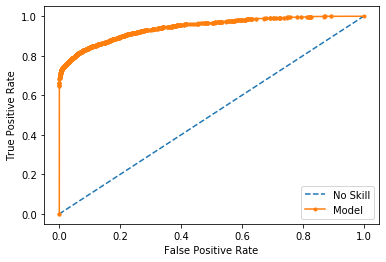

In [97]:
roc(optimal_catboost_model, X_credit_cat_test, y_credit_cat_test)